In [202]:
pip install scikit-learn

Step 1: Prepare the data and data preprocessing

In [110]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib
import streamlit as st


# Load the heart dataset
data = pd.read_csv('heart.csv')

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(exclude=['object']).columns

# Handle missing values for numerical columns using 'mean'
numerical_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])

# Handle missing values for categorical columns using 'most_frequent'
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Clean column names by stripping any leading/trailing spaces
data.columns = data.columns.str.strip()

# Print first 5 rows of the dataset
print(data.head())
print("\n\n")
print(data.info())

    Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0 40.00   M           ATA     140.00       289.00       0.00     Normal   
1 49.00   F           NAP     160.00       180.00       0.00     Normal   
2 37.00   M           ATA     130.00       283.00       0.00         ST   
3 48.00   F           ASY     138.00       214.00       0.00     Normal   
4 54.00   M           NAP     150.00       195.00       0.00     Normal   

   MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0 172.00              N     0.00       Up          0.00  
1 156.00              N     1.00     Flat          1.00  
2  98.00              N     0.00       Up          0.00  
3 108.00              Y     1.50     Flat          1.00  
4 122.00              N     0.00       Up          0.00  



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0 

In [ ]:
Step 2 and 3 : Feature Extraction and Split the Data

In [111]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif

# Select features that might impact heart disease
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'RestingECG']
X = data[features].copy()
y = data['HeartDisease'].values

# Encode the categorical feature 'RestingECG' using LabelEncoder
label_encoder = LabelEncoder()
X['RestingECG'] = label_encoder.fit_transform(X['RestingECG'])

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=2)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Feature extraction
# 1. Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_balanced)

# 2. Feature selection
# Using ANOVA F-value to select the top 10 features
feature_selector = SelectKBest(score_func=f_classif, k=10)
X_selected = feature_selector.fit_transform(X_poly, y_balanced)

# Split the data into training and test sets with extracted features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_balanced, test_size=0.2, random_state=2)

# Check the shape of the new feature set
print(f"Original feature shape: {X_poly.shape}")
print(f"Selected feature shape: {X_selected.shape}")

Original feature shape: (1016, 20)
Selected feature shape: (1016, 10)


Step 4 & 5: Fit Model and Predict Outcomes ,Train and Evaluate the Model

KNN


KNN Accuracy: 0.79
KNN ROC-AUC Score: 0.83

KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80       107
         1.0       0.78      0.78      0.78        97

    accuracy                           0.79       204
   macro avg       0.79      0.79      0.79       204
weighted avg       0.79      0.79      0.79       204



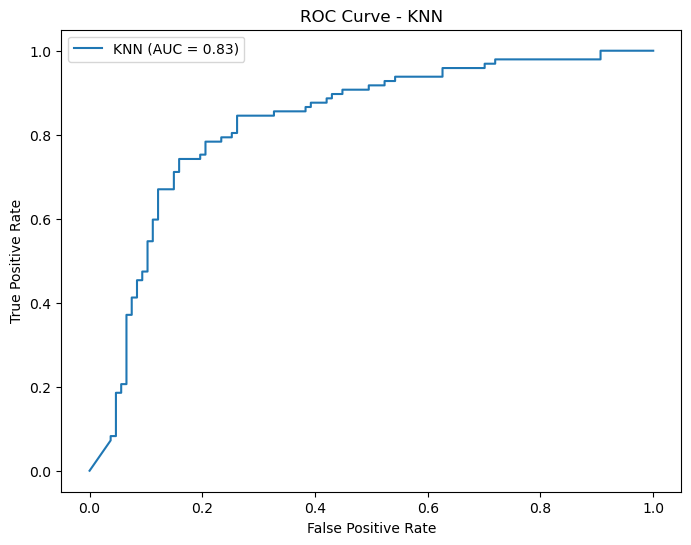

In [112]:
# Function to train and evaluate KNN model
def train_knn_model():
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_knn = grid_search.best_estimator_

    # Evaluate the model
    y_pred = best_knn.predict(X_test)
    y_prob = best_knn.predict_proba(X_test)[:, 1]  # Probability predictions for ROC-AUC

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nKNN Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"KNN ROC-AUC Score: {roc_auc:.2f}")
    print(f"\nKNN Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - KNN')
    plt.legend(loc='best')
    plt.show()

    return best_knn

# Train and evaluate KNN model
knn = train_knn_model()

ANN


ANN Accuracy: 0.73
ANN ROC-AUC Score: 0.83

ANN Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.69      0.73       107
         1.0       0.69      0.77      0.73        97

    accuracy                           0.73       204
   macro avg       0.73      0.73      0.73       204
weighted avg       0.73      0.73      0.73       204



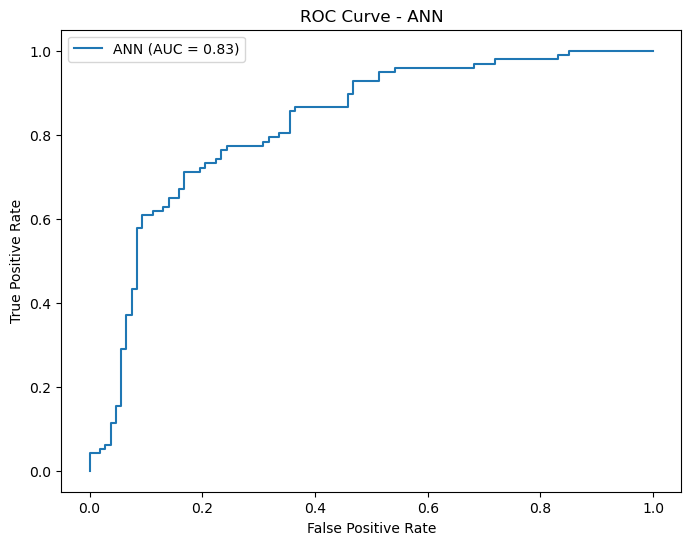

In [113]:
# Function to train and evaluate ANN model
def train_ann_model():
    ann = MLPClassifier(max_iter=3000, random_state=2)
    param_grid = {'hidden_layer_sizes': [(10,), (20,), (10, 10)], 'alpha': [0.0001, 0.001, 0.01]}
    grid_search = GridSearchCV(ann, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_ann = grid_search.best_estimator_
    
    # Evaluate the model
    y_pred = best_ann.predict(X_test)
    y_prob = best_ann.predict_proba(X_test)[:, 1]  # Probability predictions for ROC-AUC
    
    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nANN Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"ANN ROC-AUC Score: {roc_auc:.2f}")
    print(f"\nANN Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ANN (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ANN')
    plt.legend(loc='best')
    plt.show()
    
    return best_ann

ann = train_ann_model()

SVM




SVM Accuracy: 0.75
SVM ROC-AUC Score: 0.83

SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       107
         1.0       0.74      0.74      0.74        97

    accuracy                           0.75       204
   macro avg       0.75      0.75      0.75       204
weighted avg       0.75      0.75      0.75       204



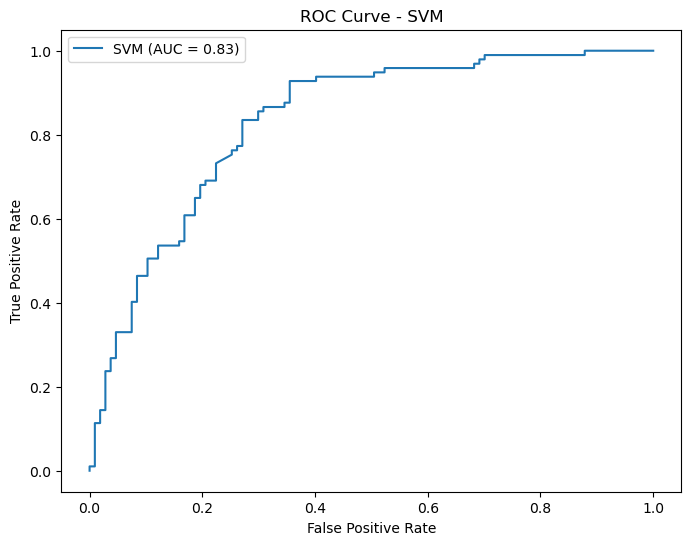

In [114]:
# Function to train and evaluate SVM model
def train_svm_model():
    svm = SVC(probability=True)
    param_grid = {'kernel': ['linear', 'rbf', 'poly'], 'C': [0.1, 1, 10]}
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_svm = grid_search.best_estimator_
    
    # Evaluate the model
    y_pred = best_svm.predict(X_test)
    y_prob = best_svm.predict_proba(X_test)[:, 1]  # Probability predictions for ROC-AUC
    
    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nSVM Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"SVM ROC-AUC Score: {roc_auc:.2f}")
    print(f"\nSVM Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='best')
    plt.show()
    
    return best_svm

svm = train_svm_model()

In [115]:
# Function to save all models and preprocessing steps
def save_all_models_and_preprocessing(knn, ann, svm, scaler, label_encoder, poly, feature_selector):
    # Dictionary to hold the models and preprocessing steps
    models_and_preprocessing = {
        'knn': knn,
        'ann': ann,
        'svm': svm,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'poly': poly,
        'feature_selector': feature_selector
    }
    
    # Save all models and preprocessing steps to a single file
    joblib.dump(models_and_preprocessing, 'heart_failure_model.joblib')
    print("All models and preprocessing steps saved to 'heart_failure_model.joblib'")

# Ensure models and preprocessing steps are defined and trained
if 'knn' in locals() and 'ann' in locals() and 'svm' in locals() and 'scaler' in locals() and 'label_encoder' in locals() and 'poly' in locals() and 'feature_selector' in locals():
    save_all_models_and_preprocessing(knn, ann, svm, scaler, label_encoder, poly, feature_selector)
else:
    print("One or more components are not defined.")

All models and preprocessing steps saved to 'heart_failure_model.joblib'


In [ ]:
Step 6: Predict Unseen Data

In [116]:

# Load the saved models and preprocessing steps
models_and_preprocessing = joblib.load('heart_failure_model.joblib')

# Extract the models and preprocessing steps
knn = models_and_preprocessing['knn']
ann = models_and_preprocessing['ann']
svm = models_and_preprocessing['svm']
scaler = models_and_preprocessing['scaler']
label_encoder = models_and_preprocessing['label_encoder']
poly = models_and_preprocessing['poly']  # Load the fitted PolynomialFeatures instance
feature_selector = models_and_preprocessing['feature_selector']  # Load the fitted SelectKBest instance

# Function to handle user input and make predictions
def get_user_input():
    print("Enter the following details for heart disease prediction:")
    Age = int(input("Age: "))
    RestingBP = float(input("Resting Blood Pressure: "))
    Cholesterol = float(input("Cholesterol: "))
    MaxHR = float(input("Maximum Heart Rate: "))
    RestingECG = input("RestingECG (options: 'Normal', 'ST', 'LVH'): ")

    # Validate RestingECG input
    valid_ecg_options = ['Normal', 'ST', 'LVH']
    if RestingECG not in valid_ecg_options:
        print(f"Invalid RestingECG option. Choose from {valid_ecg_options}.")
        return None

    # Create a dictionary of the entered values
    unseen_data = {
        'Age': Age,
        'RestingBP': RestingBP,
        'Cholesterol': Cholesterol,
        'MaxHR': MaxHR,
        'RestingECG': RestingECG
    }
    return unseen_data

def predict_unseen_data(models, scaler, label_encoder, poly, feature_selector):
    unseen_data = get_user_input()  # Get input from the user
    
    if unseen_data is None:
        return  # Exit if invalid input is provided
    
    # Convert unseen data to DataFrame for processing
    unseen_df = pd.DataFrame([unseen_data])
    
    # Encode the categorical feature 'RestingECG' using the pre-fitted label encoder
    unseen_df['RestingECG'] = label_encoder.transform(unseen_df['RestingECG'])
    
    # Scale the input data using the same scaler (exclude 'HeartDisease')
    unseen_df_scaled = scaler.transform(unseen_df)
    
    # Apply polynomial transformations (degree=2)
    unseen_df_poly = poly.transform(unseen_df_scaled)
    
    # Apply feature selection to match the number of features expected by the model
    unseen_df_selected = feature_selector.transform(unseen_df_poly)
    
    # Iterate over each model to make predictions
    for model, model_name in models:
        try:
            # Predict using the loaded or in-memory model
            y_pred = model.predict(unseen_df_selected)
            
            # Get the probability prediction if the model supports it
            y_prob = model.predict_proba(unseen_df_selected)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Display results
            heart_failure = "Yes" if y_pred[0] == 1 else "No"
            print(f"\n{model_name} Results:")
            print(f"Age Entered: {unseen_data['Age']}")
            
            if y_prob is not None:
                probability = y_prob[0] * 100  # Convert to percentage
                print(f"Probability of Heart Disease: {probability:.2f}%")
            else:
                print("Probability information not available.")
            
            print(f"Heart Failure Prediction: {heart_failure}")
        except Exception as e:
            print(f"Error with {model_name} model: {e}")

# Predict for unseen data using loaded models
models = [
    (knn, "KNN"),
    (ann, "ANN"),
    (svm, "SVM")
]

predict_unseen_data(models, scaler, label_encoder, poly, feature_selector)

Enter the following details for heart disease prediction:


Age:  25
Resting Blood Pressure:  120
Cholesterol:  120
Maximum Heart Rate:  150
RestingECG (options: 'Normal', 'ST', 'LVH'):  Normal



KNN Results:
Age Entered: 25
Probability of Heart Disease: 26.49%
Heart Failure Prediction: No

ANN Results:
Age Entered: 25
Probability of Heart Disease: 33.03%
Heart Failure Prediction: No

SVM Results:
Age Entered: 25
Probability of Heart Disease: 25.14%
Heart Failure Prediction: No


In [ ]:
Step 7 : compare the models using a table


Comparison Table:
Model  Accuracy (%)  Precision (%)  Recall (%)  ROC-AUC (%)
  KNN         78.92          77.55       78.35        82.87
  ANN         73.04          69.44       77.32        82.51
  SVM         75.49          74.23       74.23        83.26


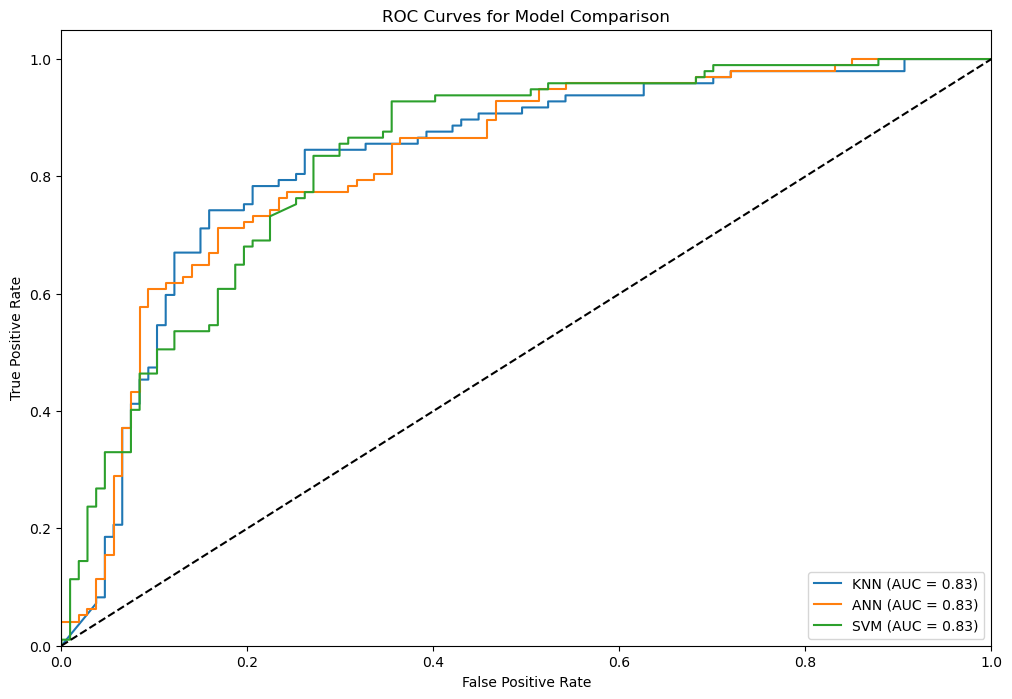

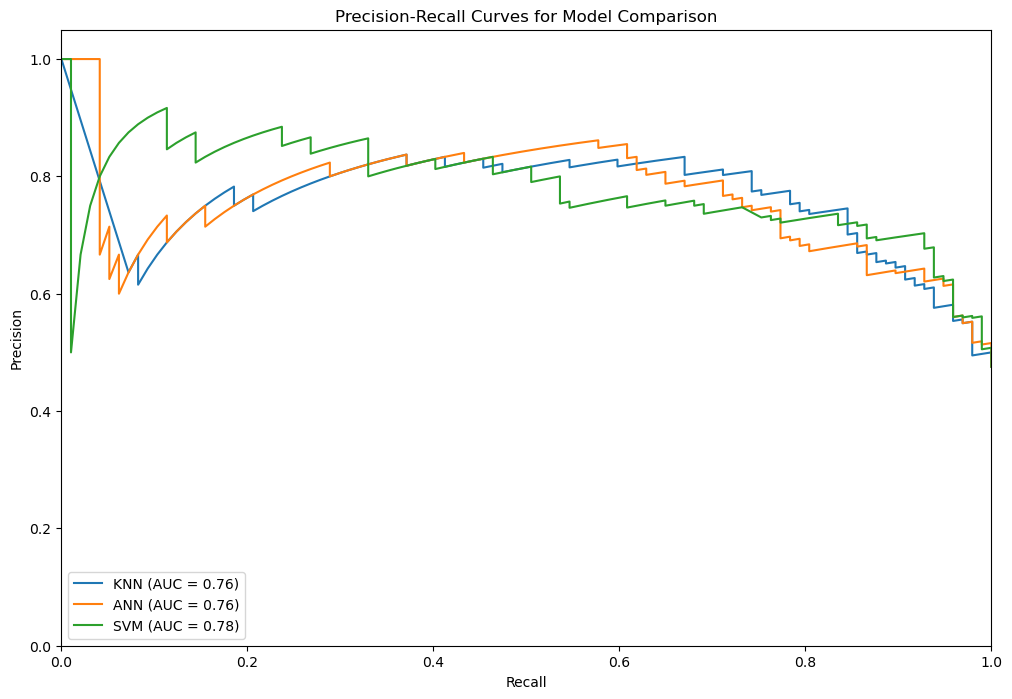

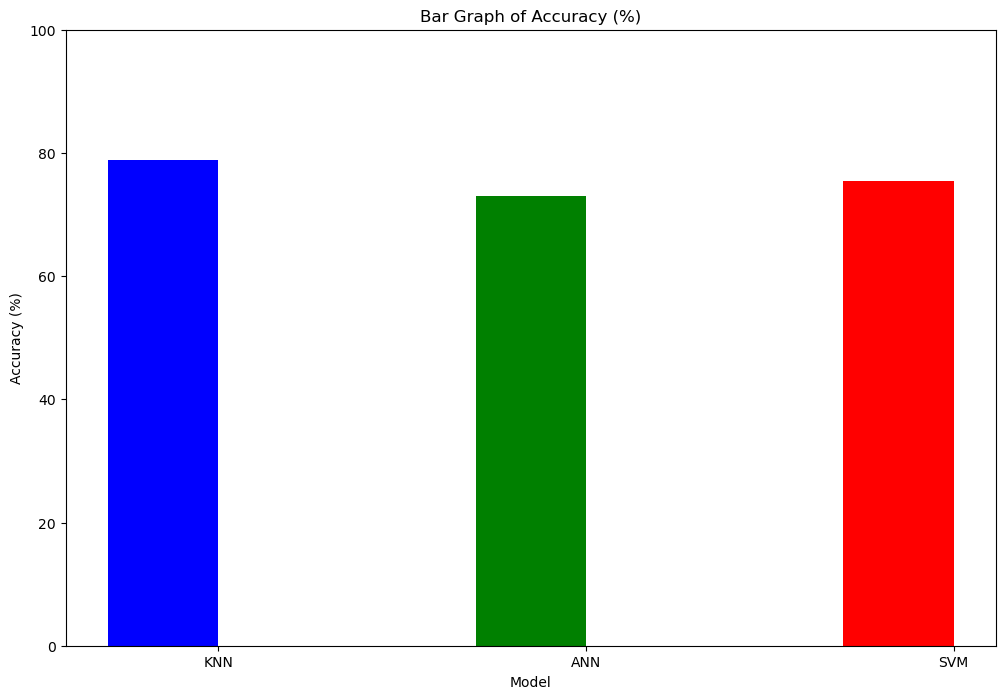

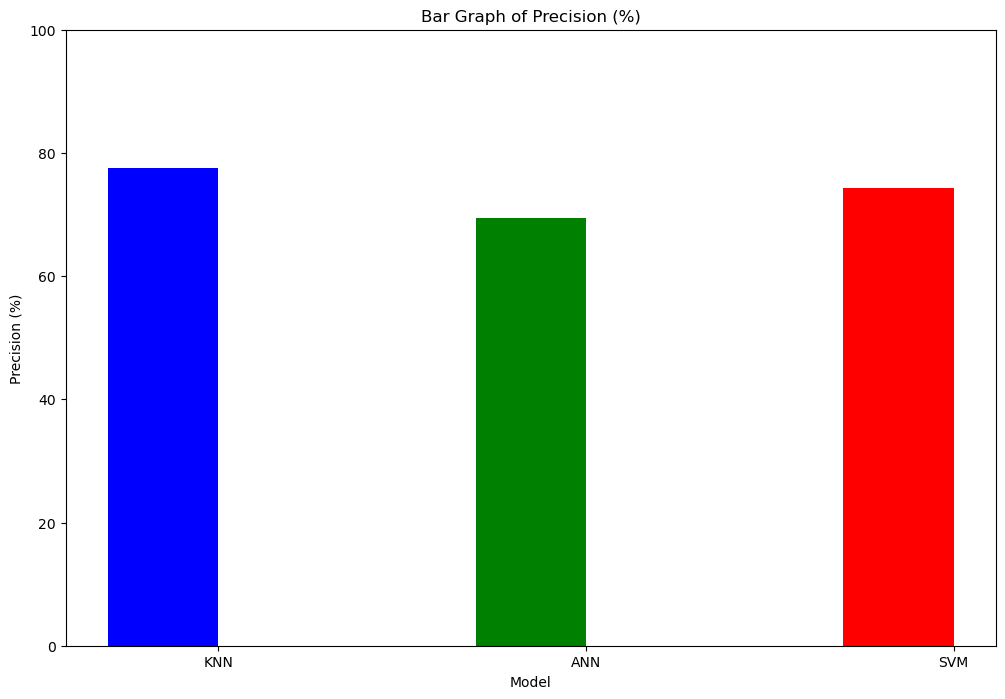

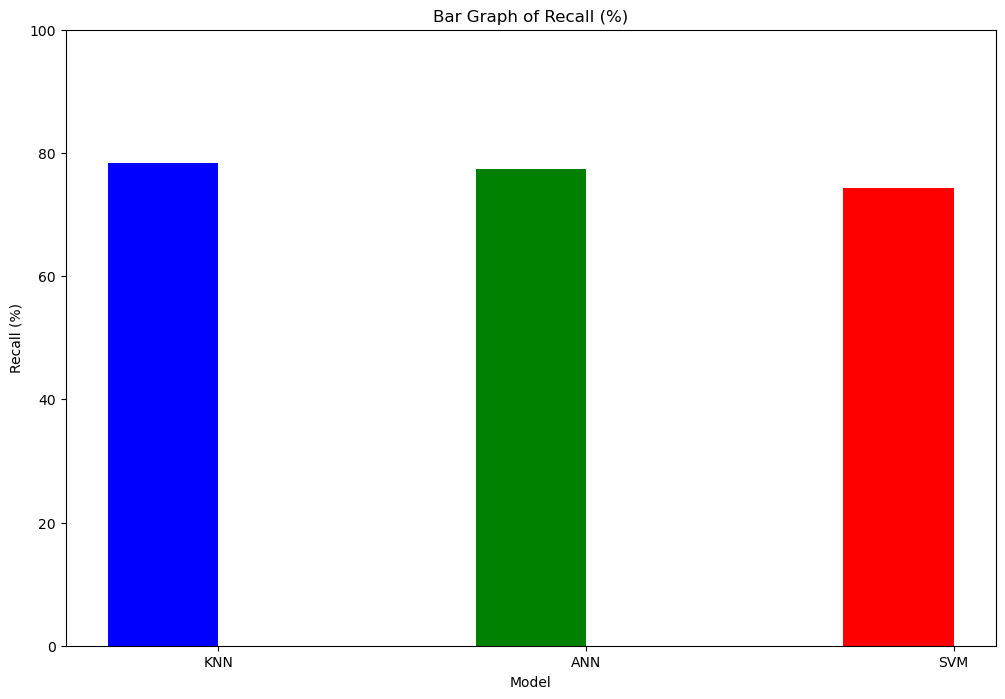

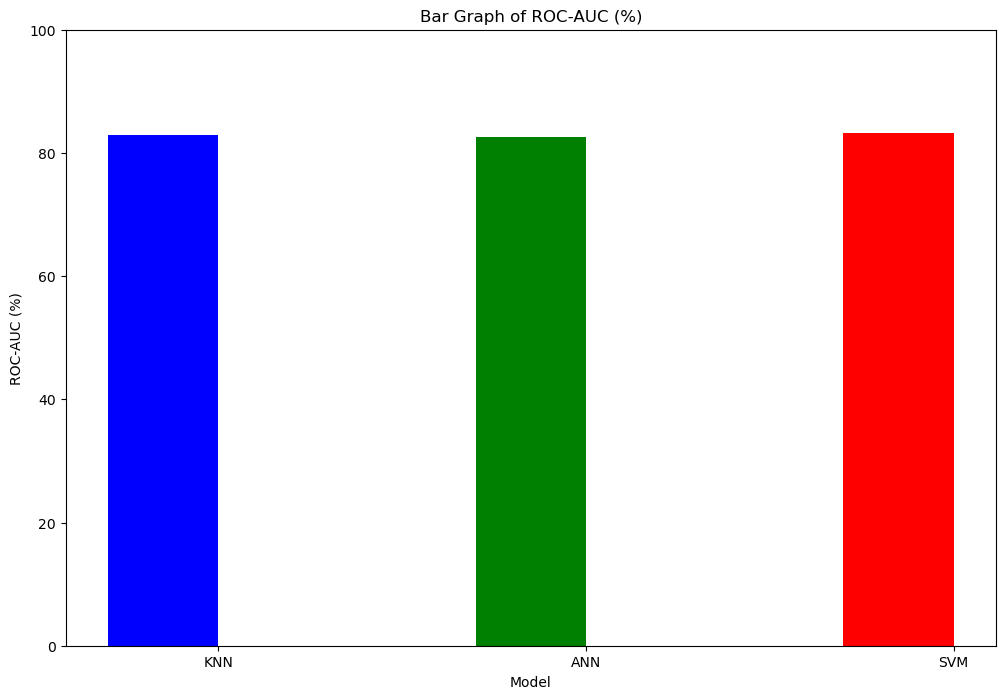

In [117]:
def compare_models():
    # Load all models and preprocessing steps
    data = joblib.load('heart_failure_model.joblib')
    
    knn = data['knn']
    ann = data['ann']
    svm = data['svm']
    scaler = data['scaler']
    label_encoder = data['label_encoder']
    
    # Prepare for evaluation
    results = []
    roc_curves = {}
    pr_curves = {}
    
    for model_name, model in zip(["KNN", "ANN", "SVM"], [knn, ann, svm]):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        accuracy = accuracy_score(y_test, y_pred) * 100
        precision = precision_score(y_test, y_pred) * 100
        recall = recall_score(y_test, y_pred) * 100
        roc_auc = roc_auc_score(y_test, y_prob) * 100 if y_prob is not None else None
        
        # ROC and PR curves
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
            roc_auc_val = auc(fpr, tpr)
            pr_auc_val = auc(recall_vals, precision_vals)
            
            roc_curves[model_name] = (fpr, tpr, roc_auc_val)
            pr_curves[model_name] = (precision_vals, recall_vals, pr_auc_val)
        
        results.append([model_name, accuracy, precision, recall, roc_auc])
    
    # Display the comparison table
    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'ROC-AUC (%)'])
    print("\nComparison Table:")
    print(results_df.to_string(index=False))
    
    # Plotting ROC Curves
    plt.figure(figsize=(12, 8))
    for model_name, (fpr, tpr, roc_auc_val) in roc_curves.items():
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_val:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Model Comparison')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plotting Precision-Recall Curves
    plt.figure(figsize=(12, 8))
    for model_name, (precision_vals, recall_vals, pr_auc_val) in pr_curves.items():
        plt.plot(recall_vals, precision_vals, label=f'{model_name} (AUC = {pr_auc_val:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Model Comparison')
    plt.legend(loc="lower left")
    plt.show()
    
    # Plotting Bar Graphs for Metrics
    metrics = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'ROC-AUC (%)']
    bar_width = 0.3  # Width of the bars
    x = np.arange(len(["KNN", "ANN", "SVM"]))  # X locations for the groups
    
    for metric_index, metric in enumerate(metrics):
        plt.figure(figsize=(12, 8))
        values = [result[metric_index + 1] for result in results]
        plt.bar(x - bar_width/2, values, width=bar_width, color=['blue', 'green', 'red'])
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.title(f'Bar Graph of {metric}')
        plt.xticks(x, ["KNN", "ANN", "SVM"])
        plt.ylim(0, 100)  # Assuming metrics are percentages
        plt.show()

# Trigger the comparison
compare_models()

Deployment(for only 1 model)

In [118]:
import streamlit as st
import pandas as pd
from joblib import load

# Load the models and preprocessing steps
heart_failure_model = load('heart_failure_model.joblib')

# Extract models and preprocessing steps
knn = heart_failure_model['knn']
scaler = heart_failure_model['scaler']
label_encoder = heart_failure_model['label_encoder']
poly = heart_failure_model['poly']
feature_selector = heart_failure_model['feature_selector']

# Set the Streamlit page configuration
st.set_page_config(page_title='Heart Failure Prediction', page_icon='❤', layout='wide')

# Custom CSS for styling the app with black background
st.markdown("""
    <style>
    body {
        background-color: #000000; /* Black */
        color: #FFFFFF; /* White text */
        font-family: 'Arial', sans-serif;
    }
    
    .main {
        padding: 20px;
        border-radius: 10px;
    }
    
    h1, h2, h3 {
        color: #FFDDDD; /* Light grey text */
        text-align: center;
        font-family: 'Arial', sans-serif;
    }

    .stButton button {
        background: linear-gradient(135deg, #ff4b4b, #ff6f6f); /* Gradient background */
        color: white;
        border-radius: 8px;
        padding: 12px 24px; /* Increased padding */
        font-size: 18px; /* Larger font size */
        border: none;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); /* Subtle shadow */
        cursor: pointer;
        transition: background-color 0.3s ease, box-shadow 0.3s ease; /* Smooth transitions */
    }

    .stButton button:hover {
        background: linear-gradient(135deg, #ff6f6f, #ff4b4b); /* Reverse gradient on hover */
        box-shadow: 0 6px 8px rgba(0, 0, 0, 0.3); /* Enhanced shadow on hover */
    }

    .sidebar .sidebar-content {
        background-color: #333333; /* Dark grey for sidebar */
    }

    .stNumberInput input, .stSelectbox select {
        border-radius: 8px;
        padding: 12px;
        font-size: 14px;
        border: 1px solid #555555;
        background-color: #222222; /* Dark background for input fields */
        color: #FFFFFF; /* White text for inputs */
    }

    .section-title {
        color: #FFDDDD; /* Light grey text */
        font-size: 22px;
        font-weight: bold;
        margin-top: 20px;
        margin-bottom: 10px;
        text-align: center; /* Center-align text */
    }

    .stProgressbar {
        background-color: #333333; /* Dark grey for progress bar */
    }
    </style>
    """, unsafe_allow_html=True)

# Sidebar for app description or instructions
st.sidebar.header("About the App")
st.sidebar.write("""
    This tool predicts the likelihood of heart failure based on factors such as age, cholesterol, heart rate, and resting ECG.
    It's powered by a K-Nearest Neighbors (KNN) model, trained on health data.
""")

st.sidebar.image("https://image-url-here.com/heart.png", use_column_width=True)

# Main content layout
with st.container():
    # Title and description
    st.title('Heart Failure Prediction System 💓')
    st.write("""
        Provide the required information below, and the system will estimate the likelihood of heart failure using machine learning.
    """)

    # Divider for clarity
    st.markdown("---")

    # Input section in two columns
    st.markdown('<div class="section-title">Patient Information</div>', unsafe_allow_html=True)
    col1, col2 = st.columns(2)

    with col1:
        age = st.number_input('Age:', min_value=0, max_value=120, step=1, help="Enter the patient's age.")
        resting_bp = st.number_input('Resting Blood Pressure (mm Hg):', min_value=0, step=1, help="Enter the resting blood pressure.")
        cholesterol = st.number_input('Cholesterol Level (mg/dl):', min_value=0, step=1, help="Enter the cholesterol level.")

    with col2:
        max_hr = st.number_input('Maximum Heart Rate (bpm):', min_value=0, step=1, help="Enter the maximum heart rate.")
        resting_ecg = st.selectbox('Resting ECG:', ['Normal', 'ST', 'LVH'], help="Select the type of resting ECG.")

    st.markdown("---")

    # DataFrame for input data
    input_df = pd.DataFrame({
        'Age': [age],
        'RestingBP': [resting_bp],
        'Cholesterol': [cholesterol],
        'MaxHR': [max_hr],
        'RestingECG': [resting_ecg]
    })

    # Check for unknown label
    if resting_ecg not in label_encoder.classes_:
        st.error(f"Unknown value '{resting_ecg}' for RestingECG. Please select from {label_encoder.classes_}.")
    else:
        # Preprocessing and prediction
        input_df['RestingECG'] = label_encoder.transform(input_df['RestingECG'])
        input_df_scaled = scaler.transform(input_df)
        input_df_poly = poly.transform(input_df_scaled)
        input_df_selected = feature_selector.transform(input_df_poly)

        # Predict button with progress bar
        if st.button('Predict Heart Failure'):
            with st.spinner('Predicting...'):
                y_pred = knn.predict(input_df_selected)
                y_prob = knn.predict_proba(input_df_selected)[:, 1]
                probability = y_prob[0] * 100
                heart_failure = "Yes" if y_pred[0] == 1 else "No"

            # Display entered details
            st.subheader("Entered Details")
            st.write(f"- *Age:* {age}")
            st.write(f"- *Resting Blood Pressure:* {resting_bp} mm Hg")
            st.write(f"- *Cholesterol Level:* {cholesterol} mg/dl")
            st.write(f"- *Maximum Heart Rate:* {max_hr} bpm")
            st.write(f"- *Resting ECG:* {resting_ecg}")
        
            # Display prediction results
            st.markdown('<div class="section-title">Prediction Results</div>', unsafe_allow_html=True)
            st.write(f"- *Heart Failure Likelihood:* {heart_failure}")
            st.write(f"- *Predicted Probability of Heart Failure:* {probability:.2f}%")

            # Visual representation of the probability
            st.progress(int(probability))

            # Display the message with custom color coding
            if y_pred[0] == 1:
                st.error("⚠ High risk of heart failure. Please consult a healthcare provider.")
            else:
                st.success("✅ Low risk of heart failure. Maintain a healthy lifestyle!")

# Footer section with resources
st.sidebar.markdown("---")
st.sidebar.write("### Useful Resources")
st.sidebar.write("- [Heart Failure Information](https://www.heart.org/en/health-topics/heart-failure)")
st.sidebar.write("- [KNN Algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)")
st.markdown("<center><p style='color:grey;'>Powered by Streamlit | Heart Failure Prediction System © 2024</p></center>", unsafe_allow_html=True)

DeltaGenerator()